### Observe Tag Trend between 2021-09 ~ 2023-09

In [84]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pandas as pd
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# Import Dataset
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT creation_date, tags
FROM questions
WHERE creation_date > '2020-09-01';
'''
df_tags = pd.read_sql_query(query, conn)
conn.close()

In [59]:
df_tags

,creation_date,tags
0,2020-09-01 00:01:13.850,"[""javascript"", ""arrays"", ""set""]"
1,2020-09-01 00:01:54.543,"[""c#""]"
2,2020-09-01 00:02:07.530,"[""java"", ""mysql"", ""api"", ""mariadb-10.1""]"
3,2020-09-01 00:02:34.410,"[""antd"", ""ant-design-pro""]"
4,2020-09-01 00:02:37.143,"[""laravel""]"
...,...,...
4350926,2023-09-03 09:32:29.237,"[""next.js"", ""supabase"", ""supabase-database""]"
4350927,2023-09-03 09:32:56.247,"[""javascript"", ""arrays"", ""html-table""]"
4350928,2023-09-03 09:33:37.100,"[""flutter"", ""kotlin"", ""dart"", ""bluetooth-lowen..."
4350929,2023-09-03 09:33:40.880,"[""python"", ""memory""]"


In [85]:
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

In [86]:
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('M') # changed from D to M
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

In [87]:
post_count = df_tags['year_month'].value_counts()

In [88]:
df_tags

,creation_date,tags,year_month
0,2020-09-01 00:01:13.850,"[""javascript"", ""arrays"", ""set""]",2020-09
1,2020-09-01 00:01:54.543,"[""c#""]",2020-09
2,2020-09-01 00:02:07.530,"[""java"", ""mysql"", ""api"", ""mariadb-10.1""]",2020-09
3,2020-09-01 00:02:34.410,"[""antd"", ""ant-design-pro""]",2020-09
4,2020-09-01 00:02:37.143,"[""laravel""]",2020-09
...,...,...,...
4350926,2023-09-03 09:32:29.237,"[""next.js"", ""supabase"", ""supabase-database""]",2023-09
4350927,2023-09-03 09:32:56.247,"[""javascript"", ""arrays"", ""html-table""]",2023-09
4350928,2023-09-03 09:33:37.100,"[""flutter"", ""kotlin"", ""dart"", ""bluetooth-lowen...",2023-09
4350929,2023-09-03 09:33:40.880,"[""python"", ""memory""]",2023-09


In [24]:
# Extract keys througout the whole data
all_keys = tag_freq(df_tags)
all_keys = pd.DataFrame(all_keys, index = ['tag']).transpose().reset_index()

# compute tagShare on each month
for i in range(len(year_month)):
    data = df_tags[df_tags['year_month'] == year_month[i]]
    tags = tag_freq(data)
    tagCount = pd.DataFrame(tags, index = ['tag']).transpose().reset_index()
    tagShare = []
    for j in range(len(tagCount)):
        tagShare.append((tagCount['tag'][j] / tagCount['tag'].sum())*100)
    tagCount['tagShare'] = tagShare
    varName = year_month[i].replace('-', '_')
    tagCount = tagCount.rename(columns = {'tag':f'tag_{varName}','tagShare':f'tagShare_{varName}'})
    # merge here.
    all_keys = pd.merge(all_keys, tagCount, on = 'index', how = 'left')

In [8]:
all_keys

,index,tag,tag_2020_09,tagShare_2020_09,tag_2020_10,tagShare_2020_10,tag_2020_11,tagShare_2020_11,tag_2020_12,tagShare_2020_12,...,tag_2023_05,tagShare_2023_05,tag_2023_06,tagShare_2023_06,tag_2023_07,tagShare_2023_07,tag_2023_08,tagShare_2023_08,tag_2023_09,tagShare_2023_09
0,javascript,477797,16761.0,3.874346,16406.0,3.798309,15504.0,3.771997,16008.0,3.893498,...,7788.0,2.878793,7560.0,2.851399,7572.0,2.879427,7757.0,2.765498,518.0,2.936341
1,arrays,75660,2744.0,0.634282,2817.0,0.652191,2763.0,0.672215,2888.0,0.702425,...,784.0,0.289802,779.0,0.293815,765.0,0.290909,734.0,0.261683,62.0,0.351454
2,set,2143,49.0,0.011326,89.0,0.020605,75.0,0.018247,86.0,0.020917,...,30.0,0.011089,30.0,0.011315,27.0,0.010267,26.0,0.009269,NaN,NaN
3,Csharp,191521,6444.0,1.489546,6186.0,1.432180,5970.0,1.452452,5727.0,1.392932,...,3837.0,1.418327,3822.0,1.441541,3891.0,1.479642,4110.0,1.465282,234.0,1.326455
4,java,233713,8924.0,2.062804,8921.0,2.065386,8465.0,2.059465,7805.0,1.898348,...,4191.0,1.549181,4305.0,1.623713,4101.0,1.559499,4452.0,1.587211,303.0,1.717590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52658,applespeech,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.005669
52659,jsonloader,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.005669
52660,livescript,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.005669
52661,nxhtml,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.005669


In [26]:
# Save via Pickle
#import pickle
#with open('tag_keys.pickle', 'wb') as fw:
#    pickle.dump(all_keys, fw)

In [36]:
# load pickle
import pickle
with open('tag_keys.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

In [37]:
# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]
df_count = df_count.fillna(0)

In [38]:
df_count

,index,tag_2020_09,tag_2020_10,tag_2020_11,tag_2020_12,tag_2021_01,tag_2021_02,tag_2021_03,tag_2021_04,tag_2021_05,...,tag_2022_12,tag_2023_01,tag_2023_02,tag_2023_03,tag_2023_04,tag_2023_05,tag_2023_06,tag_2023_07,tag_2023_08,tag_2023_09
0,javascript,16761.0,16406.0,15504.0,16008.0,16861.0,15260.0,16755.0,15842.0,15806.0,...,12489.0,12205.0,10448.0,10524.0,8302.0,7788.0,7560.0,7572.0,7757.0,518.0
1,arrays,2744.0,2817.0,2763.0,2888.0,2780.0,2618.0,2922.0,2666.0,2615.0,...,1895.0,1697.0,1377.0,1290.0,908.0,784.0,779.0,765.0,734.0,62.0
2,set,49.0,89.0,75.0,86.0,74.0,75.0,76.0,71.0,84.0,...,58.0,47.0,31.0,31.0,35.0,30.0,30.0,27.0,26.0,0.0
3,Csharp,6444.0,6186.0,5970.0,5727.0,6182.0,5790.0,6388.0,5897.0,5728.0,...,5318.0,5352.0,4755.0,4902.0,3842.0,3837.0,3822.0,3891.0,4110.0,234.0
4,java,8924.0,8921.0,8465.0,7805.0,8018.0,7576.0,8657.0,7911.0,7937.0,...,5948.0,5742.0,5185.0,5531.0,4485.0,4191.0,4305.0,4101.0,4452.0,303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52658,applespeech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52659,jsonloader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52660,livescript,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52661,nxhtml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
df_basis = df_count.iloc[:, 0:df_count.columns.get_loc('tag_2021_09')]
df_basis

,index,tag_2020_09,tag_2020_10,tag_2020_11,tag_2020_12,tag_2021_01,tag_2021_02,tag_2021_03,tag_2021_04,tag_2021_05,tag_2021_06,tag_2021_07,tag_2021_08
0,javascript,16761.0,16406.0,15504.0,16008.0,16861.0,15260.0,16755.0,15842.0,15806.0,14989.0,14745.0,14620.0
1,arrays,2744.0,2817.0,2763.0,2888.0,2780.0,2618.0,2922.0,2666.0,2615.0,2317.0,2251.0,2333.0
2,set,49.0,89.0,75.0,86.0,74.0,75.0,76.0,71.0,84.0,65.0,54.0,76.0
3,Csharp,6444.0,6186.0,5970.0,5727.0,6182.0,5790.0,6388.0,5897.0,5728.0,5621.0,5201.0,5106.0
4,java,8924.0,8921.0,8465.0,7805.0,8018.0,7576.0,8657.0,7911.0,7937.0,7576.0,6941.0,6747.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52658,applespeech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52659,jsonloader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52660,livescript,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52661,nxhtml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Count Zeros
df_basis['zeros'] = df_basis.apply(lambda row: (row == 0).sum(), axis=1)
df_basis

,index,tag_2020_09,tag_2020_10,tag_2020_11,tag_2020_12,tag_2021_01,tag_2021_02,tag_2021_03,tag_2021_04,tag_2021_05,tag_2021_06,tag_2021_07,tag_2021_08,zeros
0,javascript,16761.0,16406.0,15504.0,16008.0,16861.0,15260.0,16755.0,15842.0,15806.0,14989.0,14745.0,14620.0,0
1,arrays,2744.0,2817.0,2763.0,2888.0,2780.0,2618.0,2922.0,2666.0,2615.0,2317.0,2251.0,2333.0,0
2,set,49.0,89.0,75.0,86.0,74.0,75.0,76.0,71.0,84.0,65.0,54.0,76.0,0
3,Csharp,6444.0,6186.0,5970.0,5727.0,6182.0,5790.0,6388.0,5897.0,5728.0,5621.0,5201.0,5106.0,0
4,java,8924.0,8921.0,8465.0,7805.0,8018.0,7576.0,8657.0,7911.0,7937.0,7576.0,6941.0,6747.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52658,applespeech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
52659,jsonloader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
52660,livescript,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
52661,nxhtml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


In [41]:
# erase rows containing 365 0s and list names of basis tags.
tag_basis = list(df_basis[df_basis['zeros'] != 12]['index'])
tag_basis

['javascript',
 'arrays',
 'set',
 'Csharp',
 'java',
 'mysql',
 'api',
 'mariadb10DOT1',
 'antd',
 'antdesignpro',
 'laravel',
 'ssh',
 'ansible',
 'sshkeys',
 'sqlserver',
 'tsql',
 'join',
 'storedprocedures',
 'sqlserver2012',
 'svg',
 'bezier',
 'android',
 'androidvirtualdevice',
 'vulkan',
 'python',
 'numpy',
 'numpyndarray',
 'stringliterals',
 'reactjs',
 'asynchronous',
 'asyncawait',
 'swing',
 'jcombobox',
 'DOTnet',
 'entityframeworkcore',
 'muidatatable',
 'webscraping',
 'Cpp',
 'bitmanipulation',
 'bitwiseoperators',
 'integerpromotion',
 'kotlin',
 'layoutinflater',
 'androidinflate',
 'typescript',
 'list',
 'dictionary',
 'format',
 'visualstudio',
 'debugging',
 'progressivewebapps',
 'blazor',
 'webassembly',
 'r',
 'reactnative',
 'amazons3',
 'fetch',
 'powershell',
 'fileupload',
 'ftp',
 'ftps',
 'apachecommonsnet',
 'webpack',
 'sass',
 'gulp',
 'laravelmix',
 'androidrecyclerview',
 'angular',
 'sorting',
 'googleanalytics',
 'ads',
 'adsense',
 'publisher',

In [42]:
df_analyze = pd.concat([df_count['index'], df_count.iloc[:, df_count.columns.get_loc('tag_2021_09'):]], axis = 1)
df_analyze

,index,tag_2021_09,tag_2021_10,tag_2021_11,tag_2021_12,tag_2022_01,tag_2022_02,tag_2022_03,tag_2022_04,tag_2022_05,...,tag_2022_12,tag_2023_01,tag_2023_02,tag_2023_03,tag_2023_04,tag_2023_05,tag_2023_06,tag_2023_07,tag_2023_08,tag_2023_09
0,javascript,14404.0,13817.0,13487.0,13081.0,13987.0,12835.0,13614.0,13517.0,13382.0,...,12489.0,12205.0,10448.0,10524.0,8302.0,7788.0,7560.0,7572.0,7757.0,518.0
1,arrays,2264.0,2360.0,2360.0,2266.0,2396.0,2134.0,2365.0,2310.0,2245.0,...,1895.0,1697.0,1377.0,1290.0,908.0,784.0,779.0,765.0,734.0,62.0
2,set,57.0,69.0,83.0,55.0,75.0,78.0,58.0,60.0,69.0,...,58.0,47.0,31.0,31.0,35.0,30.0,30.0,27.0,26.0,0.0
3,Csharp,5052.0,5277.0,5593.0,5032.0,5271.0,5104.0,5682.0,5215.0,5511.0,...,5318.0,5352.0,4755.0,4902.0,3842.0,3837.0,3822.0,3891.0,4110.0,234.0
4,java,6598.0,6561.0,6905.0,6181.0,6451.0,5941.0,6581.0,6397.0,6505.0,...,5948.0,5742.0,5185.0,5531.0,4485.0,4191.0,4305.0,4101.0,4452.0,303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52658,applespeech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52659,jsonloader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52660,livescript,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52661,nxhtml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
df_analyze.iloc[:, 1:].columns

Index(['tag_2021_09', 'tag_2021_10', 'tag_2021_11', 'tag_2021_12',
       'tag_2022_01', 'tag_2022_02', 'tag_2022_03', 'tag_2022_04',
       'tag_2022_05', 'tag_2022_06', 'tag_2022_07', 'tag_2022_08',
       'tag_2022_09', 'tag_2022_10', 'tag_2022_11', 'tag_2022_12',
       'tag_2023_01', 'tag_2023_02', 'tag_2023_03', 'tag_2023_04',
       'tag_2023_05', 'tag_2023_06', 'tag_2023_07', 'tag_2023_08',
       'tag_2023_09'],
      dtype='object')

In [44]:
df_analyze.iloc[:, 0:].columns

Index(['index', 'tag_2021_09', 'tag_2021_10', 'tag_2021_11', 'tag_2021_12',
       'tag_2022_01', 'tag_2022_02', 'tag_2022_03', 'tag_2022_04',
       'tag_2022_05', 'tag_2022_06', 'tag_2022_07', 'tag_2022_08',
       'tag_2022_09', 'tag_2022_10', 'tag_2022_11', 'tag_2022_12',
       'tag_2023_01', 'tag_2023_02', 'tag_2023_03', 'tag_2023_04',
       'tag_2023_05', 'tag_2023_06', 'tag_2023_07', 'tag_2023_08',
       'tag_2023_09'],
      dtype='object')

In [45]:
result_df = pd.DataFrame(columns = ['YearMonth', 'Num_newTags', 'TotalNum_newTags', 'Num_Tags', 'TotalNum_Tags'])
for i in range(len(df_analyze.iloc[:, 1:].columns)):
    col = df_analyze.iloc[:, [0,i+1]]
    col = col[col.iloc[:,1] != 0] # filter away 0s as they indicate tags appear in later months.

    ### Edited (for tag number calculation) ###
    num_distinct_tags = len(col) # 해당 달에 올라온 전체 distinct tag 개수.
    total_num_tags = col.iloc[:,1].sum() # 해당 달에 올라온 전체 테그 수 총합.

    # Compare with basis tag (not appeared once in a previous year)
    data = col[~col['index'].isin(tag_basis)] 
    # add to the result.    
    result = pd.DataFrame({'YearMonth': [df_analyze.iloc[:, 1:].columns[i]],
                  'Num_newTags': [len(data)],
                  'TotalNum_newTags': [data.iloc[:, 1].sum()],
                  'Num_Tags' : [num_distinct_tags],
                  'TotalNum_Tags': [total_num_tags]})
    result_df = pd.concat([result_df, result], ignore_index = True)
    # update tag_basis including the outdated tags.
    tag_basis.extend(list(data['index']))

/tmp/ipykernel_2101684/371868979.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, result], ignore_index = True)


In [46]:
result_df

,YearMonth,Num_newTags,TotalNum_newTags,Num_Tags,TotalNum_Tags
0,tag_2021_09,623,767.0,19689,364719.0
1,tag_2021_10,578,683.0,19501,360196.0
2,tag_2021_11,546,625.0,19596,361772.0
3,tag_2021_12,481,610.0,19256,342401.0
4,tag_2022_01,515,621.0,19860,365843.0
5,tag_2022_02,463,536.0,19589,347879.0
6,tag_2022_03,496,605.0,20300,379635.0
7,tag_2022_04,436,530.0,19494,350808.0
8,tag_2022_05,431,562.0,19591,355874.0
9,tag_2022_06,392,520.0,19536,343889.0


In [47]:
post_count = pd.DataFrame(post_count).reset_index()

In [49]:
post_count = post_count.sort_values('year_month').reset_index(drop = True)
post_count = post_count.iloc[12:,:]

In [50]:
post_count = post_count.reset_index(drop = True)

In [51]:
result_df['Num_posts'] = post_count['count']
result_df

,YearMonth,Num_newTags,TotalNum_newTags,Num_Tags,TotalNum_Tags,Num_posts
0,tag_2021_09,623,767.0,19689,364719.0,120771
1,tag_2021_10,578,683.0,19501,360196.0,119937
2,tag_2021_11,546,625.0,19596,361772.0,120334
3,tag_2021_12,481,610.0,19256,342401.0,113365
4,tag_2022_01,515,621.0,19860,365843.0,120712
5,tag_2022_02,463,536.0,19589,347879.0,115289
6,tag_2022_03,496,605.0,20300,379635.0,125073
7,tag_2022_04,436,530.0,19494,350808.0,115894
8,tag_2022_05,431,562.0,19591,355874.0,117940
9,tag_2022_06,392,520.0,19536,343889.0,113334


In [52]:
# Normalize
result_df['norm_newTag'] = result_df['Num_newTags'] / result_df['Num_Tags']
result_df['norm_total_newTag'] = result_df['TotalNum_newTags'] / result_df['TotalNum_Tags']

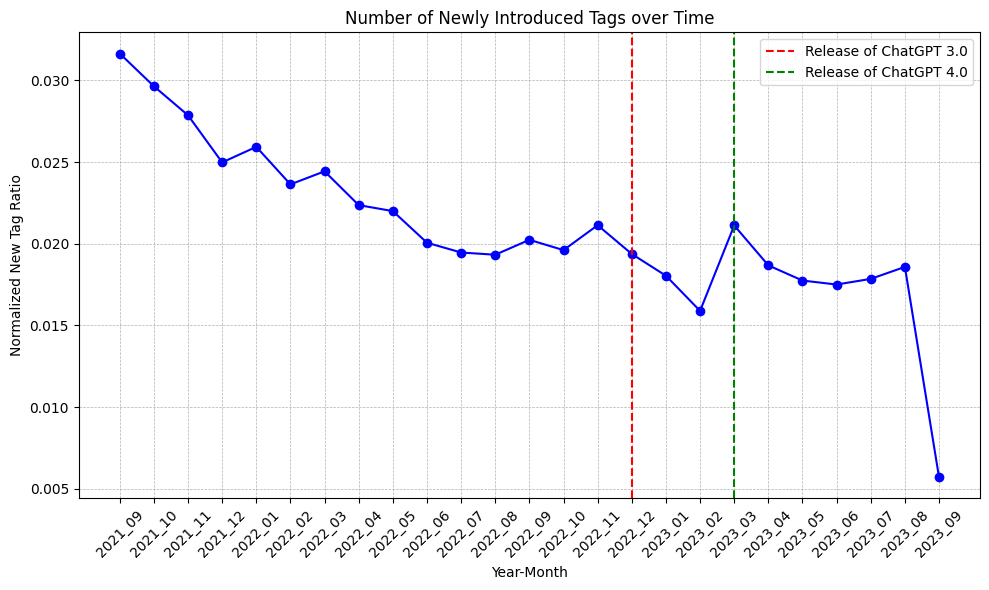

In [57]:
# Create the line plot with an additional vertical line
plt.figure(figsize=(10, 6))
plt.plot(result_df['YearMonth'].str[4:], result_df['norm_newTag'], marker='o', linestyle='-', color='blue')
plt.axvline(x='2022_12', color='red', linestyle='--', label='Release of ChatGPT 3.0')
plt.axvline(x='2023_03', color='green', linestyle='--', label='Release of ChatGPT 4.0')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Normalized New Tag Ratio')
plt.title('Number of Newly Introduced Tags over Time')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


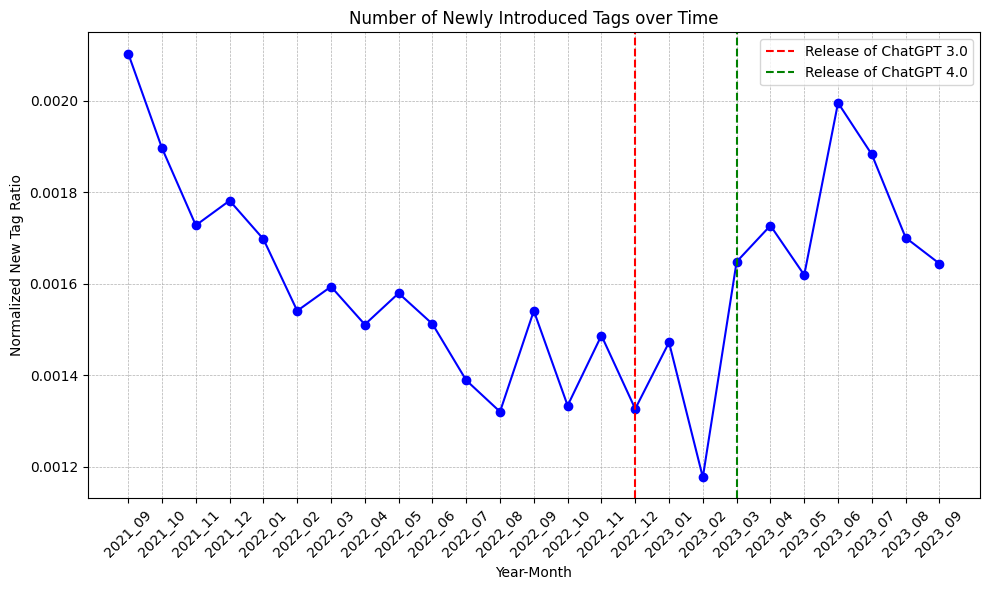

In [56]:
# Create the line plot with an additional vertical line
plt.figure(figsize=(10, 6))
plt.plot(result_df['YearMonth'].str[4:], result_df['norm_total_newTag'], marker='o', linestyle='-', color='blue')
plt.axvline(x='2022_12', color='red', linestyle='--', label='Release of ChatGPT 3.0')
plt.axvline(x='2023_03', color='green', linestyle='--', label='Release of ChatGPT 4.0')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Normalized New Tag Ratio')
plt.title('Number of Newly Introduced Tags over Time')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [22]:
# Normalize
result_df['norm_newTag'] = result_df['TotalNum_newTags'] / result_df['Num_posts']
result_df

,YearMonth,Num_newTags,TotalNum_newTags,Num_posts,norm_newTag
0,tag_2021_09,623,767.0,120771,0.006351
1,tag_2021_10,578,683.0,119937,0.005695
2,tag_2021_11,546,625.0,120334,0.005194
3,tag_2021_12,481,610.0,113365,0.005381
4,tag_2022_01,515,621.0,120712,0.005144
5,tag_2022_02,463,536.0,115289,0.004649
6,tag_2022_03,496,605.0,125073,0.004837
7,tag_2022_04,436,530.0,115894,0.004573
8,tag_2022_05,431,562.0,117940,0.004765
9,tag_2022_06,392,520.0,113334,0.004588


In [23]:
result_df['norm_newTag_vr2'] = result_df['Num_newTags'] / result_df['Num_posts']

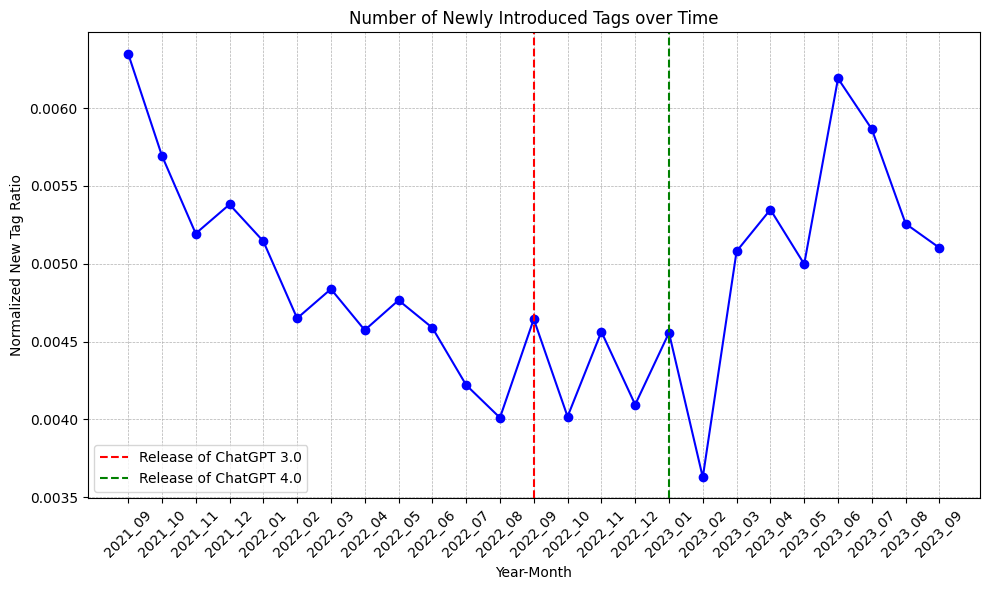

In [42]:
# Create the line plot with an additional vertical line
plt.figure(figsize=(10, 6))
plt.plot(result_df['YearMonth'].str[4:], result_df['norm_newTag'], marker='o', linestyle='-', color='blue')
plt.axvline(x='2022_09', color='red', linestyle='--', label='Release of ChatGPT 3.0')
plt.axvline(x='2023_01', color='green', linestyle='--', label='Release of ChatGPT 4.0')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Normalized New Tag Ratio')
plt.title('Number of Newly Introduced Tags over Time')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


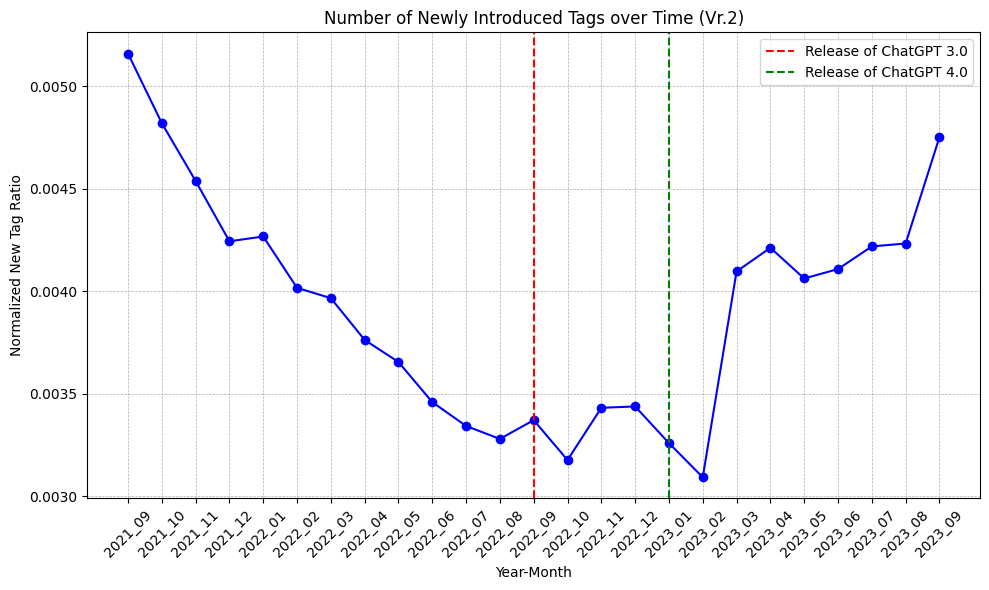

In [41]:
# Create the line plot with an additional vertical line
plt.figure(figsize=(10, 6))
plt.plot(result_df['YearMonth'].str[4:], result_df['norm_newTag_vr2'], marker='o', linestyle='-', color='blue')
plt.axvline(x='2022_09', color='red', linestyle='--', label='Release of ChatGPT 3.0')
plt.axvline(x='2023_01', color='green', linestyle='--', label='Release of ChatGPT 4.0')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Normalized New Tag Ratio')
plt.title('Number of Newly Introduced Tags over Time (Vr.2)')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# add total number of posts (questions) by each month.

In [16]:
col = df_analyze.iloc[:,[0,1]]
col

,index,tag_2021_09
0,javascript,14404.0
1,arrays,2264.0
2,set,57.0
3,Csharp,5052.0
4,java,6598.0
...,...,...
52658,applespeech,0.0
52659,jsonloader,0.0
52660,livescript,0.0
52661,nxhtml,0.0


In [17]:
col2 = col[col.iloc[:, 1] != 0]
col2

,index,tag_2021_09
0,javascript,14404.0
1,arrays,2264.0
2,set,57.0
3,Csharp,5052.0
4,java,6598.0
...,...,...
42764,jacksonannotations,1.0
42765,mox,1.0
42766,atlasplot,1.0
42767,pyramiddebugtoolbar,1.0


In [28]:
col3.iloc[:, 1].sum()

767.0

In [18]:
col3 = col2[~col2['index'].isin(tag_basis)]

In [22]:
list(col3['index'])

['barebox',
 'pdfa3',
 'maintainscrollpositionon',
 'pivotgrid',
 'compositeusertype',
 'blazorize',
 'spidev',
 'shinymanager',
 'usermanual',
 'trileadssh',
 'testbook',
 'surfacepro',
 'angularjstemplates',
 'drei',
 'ocigosdk',
 'genesysplatformsdk',
 'xdppdf',
 'instanceeval',
 'atomicboolean',
 'babashka',
 'checkly',
 'voxel51',
 'fiftyone',
 'imageannotations',
 'log4javascript',
 'gluonfx',
 'videocomponent',
 'registerglobals',
 's3rewriterules',
 'microsoftagent',
 'slackware',
 'pylzma',
 'vistimeline',
 'applicationrole',
 'rabbitmqDOTclient',
 'primus',
 'lcow',
 'stsadm',
 'candidate',
 'cryptlib',
 'lookback',
 'inappevents',
 'commandtext',
 'covariogram',
 'haiku',
 'eglibc',
 'sveltejester',
 'qshareddata',
 'comautomation',
 'googleappinvites',
 'wpd',
 'databricksml',
 'qgraphicssvgitem',
 'skypackcdn',
 'slackscim',
 'openml',
 'slim2',
 'windowsdesktopgadgets',
 'nthroot',
 'amazonlinuxextras',
 'invoice2data',
 'rubysaml',
 'dynamicmapping',
 'symfony2DOT7',
 'e

In [89]:
col3.iloc[:, 1].sum()

767.0

In [80]:
col2[~col2['index'].isin(tag_basis)].tag_2021_09.sum()

,index,tag_2021_09
42146,barebox,3.0
42147,pdfa3,1.0
42148,maintainscrollpositionon,1.0
42149,pivotgrid,1.0
42150,compositeusertype,1.0
...,...,...
42764,jacksonannotations,1.0
42765,mox,1.0
42766,atlasplot,1.0
42767,pyramiddebugtoolbar,1.0


In [ ]:
# 1) number of new unique tags
# 2) total number of new tags. (sum)
# 3) Number of total Posts (questions)

In [ ]:
# 1. tag count
# 2. total tag count
# 3. tag update.

In [ ]:
lower_bound = np.percentile(shareTrend['diff'], percentList[i]) # try 5, 10, 15, 20, 25
# filter data without outliers
cleaned_data = shareTrend[(shareTrend['diff'] >= lower_bound)]
cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
# Measure score